In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm

In [4]:
# Set the specified hyperparameters
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
Batch_size = 128
epochs = 200
step_size = 30
gamma = 0.1

In [5]:
# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
def calculate_center_si(data, label):
    n_data, n_feature = data.shape
    n_class = label.max().item() + 1

    label = label.squeeze().to(device)

    # Create a tensor to store the class centers
    class_centers = torch.zeros(n_class, n_feature, device=data.device)

    # Efficient computation of class centers for any number of features
    for i in range(n_class):
        class_members = data[label == i]
        if len(class_members) > 0:
            class_centers[i] = class_members.mean(0)

    # Compute distances to class centers
    dis_matrix = torch.cdist(data, class_centers, p=2)

    # Find the nearest class center for each data point
    _, nearest_center_labels = torch.min(dis_matrix, dim=1)

    # Calculate CSI
    csi = torch.sum(nearest_center_labels == label).float() / n_data

    return csi
def calculate_si(data, label):
    n_data = data.shape[0]

    dis_matrix = torch.cdist(data, data, p=2)
    dis_matrix.fill_diagonal_(1e10)

    # Find the nearest neighbor for each data point
    _, nearest_neighbors = torch.min(dis_matrix, dim=1)

    # Calculate SI by comparing labels of each data point with its nearest neighbor
    si = torch.sum(label == label[nearest_neighbors]).float() / n_data

    return si


In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transform for validation and test sets remains the same
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets with appropriate transforms
full_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Splitting the training set into training and validation sets
train_size = int(0.9 * len(full_train_set))
validation_size = len(full_train_set) - train_size
train_set, validation_set = random_split(full_train_set, [train_size, validation_size])

# Use the non-augmented transform for the validation set
validation_set.dataset.transform = test_transform

# Data loaders
train_loader = DataLoader(train_set, batch_size=Batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=Batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 43268675.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
model = models.vgg16(weights=None)
model.classifier[3] = nn.Linear(4096, 1024)
model.classifier[6] = nn.Linear(1024, 10)

In [9]:
def train(model, Epoch, optimizer, step_size, gamma, early_stopping_patience=5, min_delta=0.001):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Initialize StepLR
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(Epoch):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{Epoch}')
        for inputs, labels in pbar:

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / total)
        train_accuracies.append(100 * correct / total)

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(validation_loss / total)
        val_accuracies.append(100 * correct / total)

        # Update learning rate
        scheduler.step()

        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}%, Validation Loss: {val_losses[-1]}, Validation Accuracy: {val_accuracies[-1]}%')

        # Early stopping check
        val_loss = val_losses[-1]
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }


def my_plot(hist , name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(hist['train_losses'], label='Training Loss')
    plt.plot(hist['val_losses'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(hist['train_accuracies'], label='Training Accuracy')
    plt.plot(hist['val_accuracies'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.suptitle(name)
    plt.show()
def test(model):
    # Evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

def layerWise_center_si(model, data_loader, device):
    si_all = []

    features = list(model.features)
    classifier = list(model.classifier)
    all_layers = features + [model.avgpool , nn.Flatten(start_dim=1)] +classifier

    for i, layer in enumerate(all_layers):
        # Create a sub-model with the first 'i' layers
        sub_model = nn.Sequential(*all_layers[:i])
        sub_model.to(device)

        with torch.no_grad():
            output_all = []
            label_all = []
            batch_counter = 0
            for data, label in data_loader:
                # Process the data through the sub-model
                data = data.to(device)
                output = sub_model(data)

                # Flatten the output
                outputs = torch.flatten(output, start_dim=1)

                output_all.append(outputs)
                label_all.append(label)

                batch_counter += 1
                if batch_counter >= 50:
                    break

            # Concatenate all outputs and labels
            output_all = torch.cat(output_all, dim=0)
            label_all = torch.reshape(torch.cat(label_all, dim=0), (output_all.shape[0], 1))

            # Calculate Center SI
            center_si = calculate_center_si(output_all, label_all)
            si_all.append(center_si)
            print(f"Layer {i}, Output Shape: {output.shape}, Center SI is: {center_si}")

    return si_all

In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

model.to(device)
# Train the model using your training loop
history = train(model, epochs, optimizer, step_size, gamma)

Epoch 1/200: 100%|██████████| 352/352 [00:42<00:00,  8.32it/s]


Epoch 1, Train Loss: 0.0157591968509886, Train Accuracy: 21.42888888888889%, Validation Loss: 0.014089682984352111, Validation Accuracy: 30.94%


Epoch 2/200: 100%|██████████| 352/352 [00:41<00:00,  8.46it/s]


Epoch 2, Train Loss: 0.012040852636761136, Train Accuracy: 41.56444444444445%, Validation Loss: 0.011425016403198242, Validation Accuracy: 47.14%


Epoch 3/200: 100%|██████████| 352/352 [00:42<00:00,  8.31it/s]


Epoch 3, Train Loss: 0.009592611948649089, Train Accuracy: 54.9%, Validation Loss: 0.008472445154190064, Validation Accuracy: 61.7%


Epoch 4/200: 100%|██████████| 352/352 [00:42<00:00,  8.37it/s]


Epoch 4, Train Loss: 0.00787918739716212, Train Accuracy: 64.00444444444445%, Validation Loss: 0.008058634662628173, Validation Accuracy: 63.86%


Epoch 5/200: 100%|██████████| 352/352 [00:42<00:00,  8.36it/s]


Epoch 5, Train Loss: 0.006597385646237268, Train Accuracy: 70.46888888888888%, Validation Loss: 0.006425470542907714, Validation Accuracy: 72.14%


Epoch 6/200: 100%|██████████| 352/352 [00:42<00:00,  8.36it/s]


Epoch 6, Train Loss: 0.005662633746862412, Train Accuracy: 74.9%, Validation Loss: 0.006952979981899261, Validation Accuracy: 70.36%


Epoch 7/200: 100%|██████████| 352/352 [00:42<00:00,  8.32it/s]


Epoch 7, Train Loss: 0.004773831884066264, Train Accuracy: 79.07777777777778%, Validation Loss: 0.0062201785445213315, Validation Accuracy: 73.66%


Epoch 8/200: 100%|██████████| 352/352 [00:42<00:00,  8.35it/s]


Epoch 8, Train Loss: 0.00414474086827702, Train Accuracy: 81.82%, Validation Loss: 0.006067648220062256, Validation Accuracy: 76.38%


Epoch 9/200: 100%|██████████| 352/352 [00:42<00:00,  8.37it/s]


Epoch 9, Train Loss: 0.003432277837395668, Train Accuracy: 85.09555555555555%, Validation Loss: 0.0058151736974716185, Validation Accuracy: 76.96%


Epoch 10/200: 100%|██████████| 352/352 [00:42<00:00,  8.37it/s]


Epoch 10, Train Loss: 0.002868222951557901, Train Accuracy: 87.41777777777777%, Validation Loss: 0.005354474967718124, Validation Accuracy: 78.86%


Epoch 11/200: 100%|██████████| 352/352 [00:42<00:00,  8.36it/s]


Epoch 11, Train Loss: 0.0024490986867083445, Train Accuracy: 89.28222222222222%, Validation Loss: 0.0056972118943929674, Validation Accuracy: 78.72%


Epoch 12/200: 100%|██████████| 352/352 [00:42<00:00,  8.35it/s]


Epoch 12, Train Loss: 0.002113211629788081, Train Accuracy: 90.71555555555555%, Validation Loss: 0.006135355401039123, Validation Accuracy: 77.94%


Epoch 13/200: 100%|██████████| 352/352 [00:42<00:00,  8.37it/s]


Epoch 13, Train Loss: 0.001768481721646256, Train Accuracy: 92.33777777777777%, Validation Loss: 0.006155445683002472, Validation Accuracy: 77.46%


Epoch 14/200: 100%|██████████| 352/352 [00:41<00:00,  8.41it/s]


Epoch 14, Train Loss: 0.0014553053714334964, Train Accuracy: 93.62444444444445%, Validation Loss: 0.006289012295007706, Validation Accuracy: 80.2%


Epoch 15/200: 100%|██████████| 352/352 [00:42<00:00,  8.35it/s]


Epoch 15, Train Loss: 0.0012801591483255228, Train Accuracy: 94.58222222222223%, Validation Loss: 0.006437484657764435, Validation Accuracy: 79.46%
Early stopping triggered after epoch 15


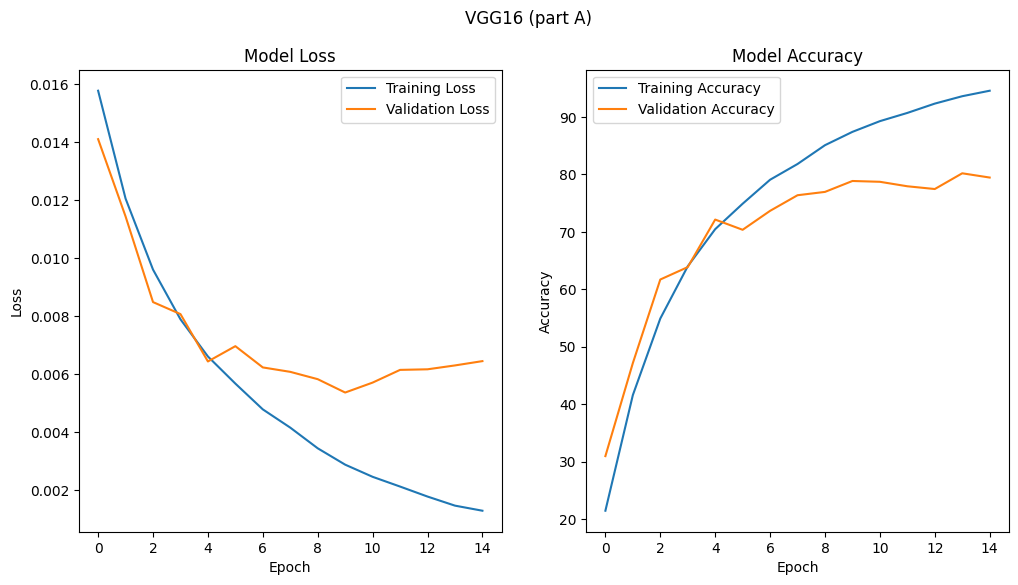

In [11]:
my_plot(history , 'VGG16 (part A)')

In [12]:
test(model)

Accuracy of the network on the 10000 test images: 78 %


In [17]:
# Save metrics
torch.save({
    'epoch': 15,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': history.get("train_losses"),
    'train_accuracies': history.get("train_accuracies"),
    'val_losses': history.get("val_losses"),
    'val_accuracies': history.get("val_accuracies"),
}, '/content/drive/MyDrive/Tahlil_Tarahi/HW04/TT_HW04_Q1_a_vgg16.pth')

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Tahlil_Tarahi/HW04/TT_HW04_Q1_a_vgg16.pth')

model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)

In [14]:
layer_si = layerWise_center_si(model , train_loader , device)

Layer 0, Output Shape: torch.Size([128, 3, 32, 32]), Center SI is: 0.2776562571525574
Layer 1, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.33203125
Layer 2, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.37718749046325684
Layer 3, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.3942187428474426
Layer 4, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.4753125011920929
Layer 5, Output Shape: torch.Size([128, 64, 16, 16]), Center SI is: 0.5001562237739563
Layer 6, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.5498437285423279
Layer 7, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.5690624713897705
Layer 8, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.5579687356948853
Layer 9, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.6315624713897705
Layer 10, Output Shape: torch.Size([128, 128, 8, 8]), Center SI is: 0.6176562309265137
Layer 11, Output Shape: torch.Size([128, 256, 8

In [15]:
layer_si_test = layerWise_center_si(model , test_loader , device)

Layer 0, Output Shape: torch.Size([128, 3, 32, 32]), Center SI is: 0.28984373807907104
Layer 1, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.33921873569488525
Layer 2, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.3884374797344208
Layer 3, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.40437498688697815
Layer 4, Output Shape: torch.Size([128, 64, 32, 32]), Center SI is: 0.46703124046325684
Layer 5, Output Shape: torch.Size([128, 64, 16, 16]), Center SI is: 0.4989062249660492
Layer 6, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.5562499761581421
Layer 7, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.5721874833106995
Layer 8, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.5642187595367432
Layer 9, Output Shape: torch.Size([128, 128, 16, 16]), Center SI is: 0.6234374642372131
Layer 10, Output Shape: torch.Size([128, 128, 8, 8]), Center SI is: 0.610156238079071
Layer 11, Output Shape: torch.Size([1

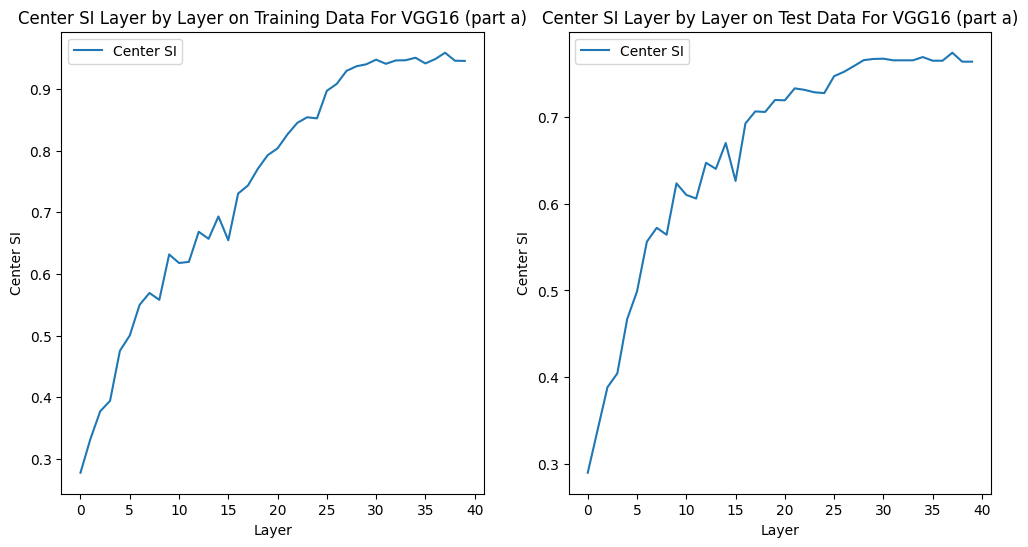

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.subplot(1, 2, 1)
plt.plot(torch.tensor(layer_si, device = 'cpu'), label='Center SI')
plt.title('Center SI Layer by Layer on Training Data For VGG16 (part a)')
plt.xlabel('Layer')
plt.ylabel('Center SI')
plt.legend()

plt.subplot(1, 2, 1)
plt.subplot(1, 2, 2)
plt.plot(torch.tensor(layer_si_test, device = 'cpu'), label='Center SI')
plt.title('Center SI Layer by Layer on Test Data For VGG16 (part a)')
plt.xlabel('Layer')
plt.ylabel('Center SI')
plt.legend()

plt.show()